# TRAIN & VALIDATION GRAPHS

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from ipywidgets import widgets
from nebfir.tools.tools_basic import key_sort_by_numbers, get_val_from_string
from IPython.display import clear_output, display
from nebfir.config.configurations import Configurations

import matplotlib.pyplot as plt


global SMOOTH
SMOOTH = 15

out = widgets.Output()

@out.capture()
def get_samples(change, *args, **kwargs):
    if change['type'] == 'change' and change['name'] == 'value':
        pass
    else:
        return
    
    clear_output()
    
    basename = Path(change['new']).stem
    basedir = Path(change['new']).parent
    cfg_file=str(basedir / basename)+'_args.yml'

    model_log_file = change['new']
        
    # READ LOG FILE
    df = pd.read_csv(model_log_file)
    epochs = df[df.part=='part'].count().part.astype(int)
    df.drop(df[df.part=='part'].index, axis=0, inplace=True)

    train_samples = df[df.part == 'train']
    validation_samples = df[df.part == 'val']

    # print('EXPERIMENT:', exp)
    print('Config:', basename)
    print('Path:', Path(model_log_file).name)
    print('Train size: ', train_samples.shape[0], '\nValidation size: ', validation_samples.shape[0])
    print('Epochs:', epochs)

    # GET DATASET SHAPE TO REPRESENT DIFFERENT SIZED TRAIN AND VALIDATION SIZES
    
    dataset_length_t = (pd.read_csv(Configurations.get_config(cfg_file)['data']['lists']['train'])).shape[0]
    dataset_length_v = (pd.read_csv(Configurations.get_config(cfg_file)['data']['lists']['test'])).shape[0]
    BATCH_SIZE = Configurations.get_config(cfg_file)['trainer']['batch_size']
       
    counterPerEpoch_t = np.ceil(dataset_length_t/BATCH_SIZE) -1 # -1 for drop last
    counterPerEpoch_v = np.ceil(dataset_length_v/BATCH_SIZE)

    times_t = np.arange(train_samples.shape[0])/counterPerEpoch_t
    times_v = np.arange(validation_samples.shape[0])/counterPerEpoch_v


    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    
    global SMOOTH

    plt.figure(figsize=(10,10))
    plt.plot(times_t, smooth(train_samples.acc.astype(float), SMOOTH), label='Train')#, color='orange')
    plt.plot(times_v, smooth(validation_samples.acc.astype(float), SMOOTH), label='Validation')#, color='green')
    plt.plot([0, epochs] , [.5, .5], color='black')
    plt.ylim([-.05, 1.05])
    plt.xlim(left=0, right=epochs)
    plt.legend()
    
    plt.xticks(list(range(0, epochs+1, (epochs+1) // 40 +1)))
    
    if save_btn.value:
        plt.savefig(model_log_file[:~3]+'.svg', dpi=300)
    
    plt.show()





options = sorted(glob('/home/andregraca/NebFIR/data/out/model_logs/model_*.txt'))

dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description='Models',
    disabled=False,
)
dropdown.observe(get_samples)

slider = widgets.IntSlider(value=SMOOTH, min=1, max=30, step=1)
def update_smooth(*args):
    global SMOOTH
    SMOOTH = slider.value
slider.observe(update_smooth)

def nothing(*args, **kwargs):
    pass
    
save_btn = widgets.Checkbox(value=False, description='Save figure')
save_btn.observe(nothing)
    
    
display(dropdown, slider, save_btn,  out)


Dropdown(description='Models', options=('/home/andregraca/NebFIR/data/out/model_logs/model_2022-05-19-13-52-23…

IntSlider(value=15, max=30, min=1)

Checkbox(value=False, description='Save figure')

Output()

# CONFUSION MATRIX

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from glob import glob
from pathlib import Path
from typing import Tuple
from IPython.display import clear_output, display
from ipywidgets import Layout, VBox, interactive, widgets

from nebfir.tools.tools_path import get_path
from nebfir.tools.tools_basic import get_val_from_string
from nebfir.tools.tools_visualization import get_subplots_shape
from nebfir.jupyter_GUIS import create_double_selection, create_button, get_widgets_output, create_checkbox, create_vbox


out = get_widgets_output()

def plot_predictions(axs: plt.Axes, axis: Tuple, mtx, user:int, user_no:int, cmap: str='seismic'):
    # Plot probabilities
    axs[axis].matshow(mtx, cmap=cmap)
    
    # Title and Labels
    axs[axis].set_title(f'User {user}')
    axs[axis].set_xlabel('Prediction')
    axs[axis].set_ylabel('Recording')
    
    # Ticks
    axs[axis].set_xticks(list(range(user_no)))
    axs[axis].set_yticks(list(range(user_no)))
    axs[axis].set_xticks(np.arange(-.5, user_no-1, 1), minor=True)
    axs[axis].set_yticks(np.arange(-.5, user_no-1, 1), minor=True)
    axs[axis].set_xticklabels(list(range(user_no)))
    axs[axis].set_yticklabels(list(range(user_no)))
    axs[axis].tick_params(which='major', bottom=False, top=True, left=True, right=False)
    axs[axis].tick_params(which='minor', bottom=False, top=True, left=True, right=False, length=2, color='r')

    # Grid
    axs[axis].grid(which='minor',color='w', linestyle='-', linewidth=.25)
    
    # Plot text probabilities
    for (i, j), z in np.ndenumerate(mtx):
        if z>0:
            col = (0, 0, 0) if .8 >= z >= .2 else (1, 1, 1)
            axs[axis].text(j, i, f'{z:0.1f}', ha='center', va='center', color=col, size=9)


def build_conf_mtx(fname, user_no, acc, figsize=(15,15), cmap='seismic', save=False, show_samples=False):
    
    print('List: ', Path(fname).name)
    print('Acc:', acc, '%')
    # Load predictions
    df = pd.read_json(fname)
        
    fig_shape = get_subplots_shape(user_no)
    _, axs = plt.subplots(*fig_shape,figsize=figsize)    
    
    sum_=0
    final_prediction_table = np.zeros((user_no,user_no), dtype=float)
    for user in range(user_no):
        axis=(fig_shape[0] *user// user_no , user%fig_shape[1])
        
        df_user = df[df.label==user] # prediction, recording
        
        # Samples
        samples_mtx = np.zeros((user_no,user_no), dtype=int)
        np.add.at(samples_mtx, (df_user.recording.to_numpy(), df_user.prediction.to_numpy()), 1) # add 1 for each (prediction, recording) pair
        
        # Probabilities
        prob_mtx = np.nan_to_num(samples_mtx / samples_mtx.sum(axis=1)[:,None], nan=0 ).astype(float)
        plot_predictions(axs=axs, axis=axis, mtx=samples_mtx if show_samples else prob_mtx, user=user, user_no=user_no, cmap=cmap)
        
        line = samples_mtx.sum(axis=0) if show_samples else prob_mtx.sum(axis=0) # prob_mtx samples_mtx
        
        line = prob_mtx.mean(axis=1)
        # print(line)
        
        final_prediction_table[user,:] = line
        # print(line)
        
        # sum_+=prob_mtx[:,user].sum()
    # print('ACC:',sum_)
        
    

    pth = Path(fname)
    
    ##########################################################################################
    # plt.savefig(f'conf_mtx.svg', dpi=300)
    ##########################################################################################
    
    if save:
        plt.savefig(os.path.join(pth.parent, f'{pth.stem}_conf_mtx.svg'), dpi=300)
    # plt.savefig('conf_mtx.svg', dpi=300)
    plt.show()


def build_new_conf_mtx(fname, user_no, acc, figsize=(15,15), cmap='seismic', save=False, show_samples=False):
    df = pd.read_json(fname)

    df_filtered = df

    for label in range(user_no):
        df_filtered = df[ (df['recording']==df['label']) & (df['label']==label) ] 
        
        
    samples_mtx = np.zeros((user_no, user_no), dtype=int)
    np.add.at(samples_mtx, (df_filtered.label.to_numpy(), df_filtered.prediction.to_numpy()), 1) # Label, Prediction

    final_prediction_table = samples_mtx / samples_mtx.sum(axis=1) if not show_samples else samples_mtx
        

def build_normal_confusion_matrix(fname, user_no, acc, figsize=(15,15), cmap='seismic', save=False, show_samples=False):
    
    print('List: ', Path(fname).name)
    print('Acc:', acc, '%')
    # Load predictions
    df = pd.read_json(fname)

    df_filtered = df
    # df_filtered = df[ (df['recording']==df['label']) & (df['user']==df['label'])] #df[df['recording']==df['label']]
    # df_filtered = df[ (df['recording']==df['label']) ] #df[df['recording']==df['label']]
    
    samples_mtx = np.zeros((user_no, user_no), dtype=int)
    np.add.at(samples_mtx, (df_filtered.label.to_numpy(), df_filtered.prediction.to_numpy()), 1) # Label, Prediction

    final_prediction_table = samples_mtx / samples_mtx.sum(axis=1) if not show_samples else samples_mtx
        
    _ = plt.figure(num=0, figsize=figsize)    
    plt.matshow(final_prediction_table, cmap=cmap, fignum=0)
    
    # Title and Labels
    plt.suptitle(f'Predictions Probabilities')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    
    # Ticks
    plt.xticks(list(range(user_no)))
    plt.yticks(list(range(user_no)))
    plt.xticks(np.arange(0, user_no, 1))
    plt.yticks(np.arange(0, user_no, 1))
    plt.tick_params(which='major', bottom=False, top=True, left=True, right=False)
    plt.tick_params(which='minor', bottom=False, top=True, left=True, right=False, length=2, color='r')
    
    # Grid
    plt.grid(which='minor',color='w', linestyle='-', linewidth=.25)
    
    # Plot text probabilities
    for (i, j), z in np.ndenumerate(final_prediction_table):
        if z>0:
            if not show_samples:
                col = (0, 0, 0) if .8 >= z >= .2 else (1, 1, 1)
            else:
                col = (0, 0, 0)
            plt.text(j, i, f'{z:0.2f}' if not show_samples else z, ha='center', va='center', color=col, size=9)



    if save_btn.value:
        plt.savefig( fname[:~3] +'svg', dpi=300)

    plt.show()


def get_predictions(name:str):   
    print('Predictions list:', name)
    
    with open(name.replace('_PREDICTIONS.json', '.json') , 'r') as jfile:
        jdict=json.load(jfile)

        train_list = jdict.get('train_list')
        test_list = jdict.get('test_list')
        user_no = jdict.get('userno')
        acc = round(float(jdict.get('accuracy')) * 100, 3)
        description = jdict.get('description')
        
        print('\nTrain List:', train_list)
        print('Test List:', test_list )
        print('Accuracy:', acc, '%')
        print('Description:', description)
    
    return name, user_no, acc


@out.capture()
def on_button_clicked(*args):
    clear_output()
    build_normal_confusion_matrix(*interactive_element2.result, show_samples=samples_button.value, figsize=(size_slider.value, size_slider.value), cmap=cmaps_dropdown.value)

def nothing(*args, **kwargs): pass


###### DISPLAY ######

tests_dir = get_path(level=('model','tests'))
predictions_available={
    'json':sorted(glob( tests_dir + 'test_model_*PREDICTIONS.json')),
    # 'elements':sorted(glob( tests_dir + 'test_model_EXP*PREDICTIONS.json')),
    }


interactive_element1, interactive_element2 = create_double_selection(get_predictions, predictions_available)

samples_button = create_checkbox(lambda _ : _, name='Samples')
size_slider = widgets.IntSlider(15, min=5, max=30, step=5, name='Fig Size')
cmaps_dropdown = widgets.Dropdown(options=['seismic', 'jet', 'turbo', 'gray'], value='jet', description='Cmap')

create_graph_button = create_button(on_button_clicked, name='Graph')
    
save_btn = widgets.Checkbox(value=False, description='Save figure')
save_btn.observe(nothing)
    
    
vbox = create_vbox(interactive_element1, interactive_element2, samples_button, size_slider, cmaps_dropdown, save_btn, create_graph_button, out)
vbox


# TEST RESULTS

## All results

In [2]:
from nebfir.env import *
from nebfir.tools.tools_path import join_paths, get_path
from nebfir.tools.tools_basic import get_val_from_string
from nebfir.config.configurations import Configurations

def get_data(test_models_path):
    
    data = []
    for model_path in test_models_path:
        with open(model_path, 'r') as jfile:
            jdict = json.load(jfile)

            try:
                cfg_file = jdict['cfg']
            except KeyError:
                cfg_file = jdict['experience']
            
            if isinstance(cfg_file, str):  cfg_file = [cfg_file]

            date = jdict["date"]
            model = jdict["model"]
            userno = jdict['userno']
            
            test_list = jdict['test_list']
            
            train_list = jdict.get('train_list')#, Configurations.load_multiple_cfg(cfg_file)['data']['lists']['train'] ) 
            
            accuracy = round(float(jdict['accuracy'])*100, 3)
            
            description = jdict.get("description", 'No description')
            
            data.append(["_&_".join(cfg_file), date, model, userno, Path(train_list).stem, Path(test_list).stem, accuracy, description])

    return data
        
test_models_path = sorted(glob(join_paths(get_path(level=('runs')), '*','*[!*PREDICTIONS].json'), recursive=True)) # NEW TESTS
# test_models_path = sorted(glob(join_paths(get_path(level=('model','tests')), 'test_model_*[!*PREDICTIONS].json'))) # NEW TESTS
# print(len(test_models_path))
# print((test_models_path))

    
data = get_data(test_models_path)
df = pd.DataFrame(data, columns=['cfg', 'date', 'model', 'userno','train_list',  'test_list', 'accuracy', 'description'])
df0=df.sort_values(by=['cfg','train_list', 'test_list', 'accuracy',], ascending=False) # test_list train_list acc


df0

,cfg,date,model,userno,train_list,test_list,accuracy,description
5,configs/config-5.yml_&_configs/base_timesforme...,"06 June 2022, 19h:04m:50s",model_2022-06-06-19-01-56,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,100.000,Train the model on the SynFED dataset. Use the...
11,configs/config-5.yml,"06 June 2022, 19h:09m:19s",data/out/weights/model_2022-06-02-11-06-12.pth,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,99.478,Train the model on the SynFED dataset.
4,configs/config-4.yml_&_configs/base_timesforme...,"06 June 2022, 19h:01m:54s",model_2022-06-06-18-58-50,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,99.437,Train the model on the SynFED dataset. Use the...
10,configs/config-4.yml,"06 June 2022, 19h:08m:30s",data/out/weights/model_2022-06-02-09-19-02.pth,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,97.058,Train the model on the SynFED dataset.
3,configs/config-3.yml_&_configs/base_timesforme...,"06 June 2022, 18h:58m:47s",model_2022-06-06-18-55-42,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,98.769,Train the model on the SynFED dataset. Use the...
9,configs/config-3.yml,"06 June 2022, 19h:07m:50s",data/out/weights/model_2022-06-02-07-44-18.pth,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,95.117,Train the model on the SynFED dataset.
2,configs/config-2.yml_&_configs/base_timesforme...,"06 June 2022, 18h:55m:39s",model_2022-06-06-18-52-42,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,97.287,Train the model on the SynFED dataset. Use the...
8,configs/config-2.yml,"06 June 2022, 19h:07m:10s",data/out/weights/model_2022-06-02-06-22-44.pth,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,86.790,Train the model on the SynFED dataset.
1,configs/config-1.yml_&_configs/base_timesforme...,"06 June 2022, 18h:52m:40s",model_2022-06-06-18-49-31,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,78.235,Train the model on the SynFED dataset. Use the...
7,configs/config-1.yml,"06 June 2022, 19h:06m:25s",data/out/weights/model_2022-06-02-05-15-18.pth,30,SynFED_TRAIN_events_aets40_test-split30_S1_Fde...,SynFED_TEST_events_aets40_test-split30_S1_Fdee...,73.727,Train the model on the SynFED dataset.


## S3DFM - Deepfakes_v1 comparision

In [4]:
import pandas as pd
import itertools
from glob import glob
import json



def get_accuracy(combination, DEBUG=False, exp_range=(116,130)):
    split_size = 30
    users='0--29' # '*' 
    
    files = []
    for exp in range(*exp_range,1): # Filter experiences
        files.extend(glob(f'data/out/tests/test_model_*EXP{exp}*test*{combination[0].lower()}*test-split{split_size}*_F{combination[2].lower()}_U{users}*[!*PREDICTIONS].json') )

    accuracies = [-1]
    for file in files:
        with open(file) as f:
            jdict = json.load(f)
            
            accuracy = float(jdict['accuracy'])
            train_list = jdict['train_list']
            
            if 'F'+combination[1].lower()+'_' in train_list:
                accuracies.append(accuracy)
            
            if DEBUG:
                print(jdict['experience'])
                print(train_list)
                print(jdict['test_list'])
                print(accuracy)
            
    return max(accuracies)



split = ['Train', 'Test']
datatype_ = ['Events', 'Grayscale']
folder_ = ['S3DFM', 'Deepfakes_v1', 'S3DFM-Deepfakes_v1']


iterables = [datatype_, folder_]
index = pd.MultiIndex.from_product(iterables, names=['Data_Type', 'Train'])


df = pd.DataFrame({l: ['---']*len(folder_)*len(datatype_) for l in folder_}, index=index)
df.columns.name = 'Test'


list_combinations = list(itertools.product(*[datatype_, folder_, folder_]))
for combination in list_combinations:
    df.loc[(combination[0], combination[1]), combination[2]] = get_accuracy(combination, DEBUG=False, exp_range=(0, 999))

print('Train S3DFM-Deepfakes_v1 w/ 10 random')
df
# print(df.to_latex())



Train S3DFM-Deepfakes_v1 w/ 10 random


Test                         S3DFM Deepfakes_v1 S3DFM-Deepfakes_v1
Data_Type Train                                                   
Events    S3DFM                 -1           -1                 -1
          Deepfakes_v1          -1           -1                 -1
          S3DFM-Deepfakes_v1    -1           -1                 -1
Grayscale S3DFM                 -1           -1                 -1
          Deepfakes_v1          -1           -1                 -1
          S3DFM-Deepfakes_v1    -1           -1                 -1

In [9]:
import pandas as pd
import itertools
from glob import glob
import json



def get_accuracy(combination, DEBUG=False, exp_range=(200,220)):
    split_size = 30
    users='*' #0--29'
    
    files = []
    for exp in range(*exp_range,1): # Filter experiences
        # files.extend(glob(f'data/out/tests/test_model_*EXP{exp}*TEST_{combination[0].lower()}_test-split{split_size}*_F{combination[2].lower()}_U{users}*[!*PREDICTIONS].json') )
        files.extend(glob(f'data/out/tests/test_model_*EXP{exp}*TEST_{combination[0].lower()}_test-split{split_size}*_F{combination[2].lower()}_U{users}*[!*PREDICTIONS].json') )

    accuracies = [-1]
    accs_dict = {}
    for file in files:
        with open(file) as f:
            jdict = json.load(f)
            
            accuracy = float(jdict['accuracy'])
            train_list = jdict['train_list']
            
            if 'realno-10_fakeno-'+str(combination[1])+'_' in train_list:
                accuracies.append(accuracy)
                accs_dict[str(jdict['model'])] = accuracy
            
                if DEBUG:
                    print(jdict['experience'])
                    print(jdict['model'])
                    print(file)
                    print(train_list)
                    # print(jdict['test_list'])
                    print(accuracy)
    
    
    return max(accuracies), max(accs_dict, key=accs_dict.get) if accs_dict else 'No values yet'



split = ['Train', 'Test']
datatype_ = ['Events', 'Grayscale']
train_folder = [2,5,10,15,
                20, 
                25, 
                29]
test_folder = ['Deepfakes_v1-S3DFM', 'Deepfakes_v1']


iterables = [datatype_, train_folder]
index = pd.MultiIndex.from_product(iterables, names=['Data_Type', 'Train'])


df = pd.DataFrame({'Deepfakes_v1-S3DFM': ['---']*len(train_folder)*len(datatype_) }, index=index)
df.columns.name = 'Test'


list_combinations = list(itertools.product(*[datatype_, train_folder, test_folder]))
# print(list_combinations)
for combination in list_combinations:
    acc, model = get_accuracy(combination, DEBUG=False, exp_range=(0, 999))
    # print(model)
    # print(combination, model)
    df.loc[(combination[0], combination[1]), combination[2]] = acc


# df.loc[('Events', 25), test_folder[0]] = .9931
# df.loc[('Events', 25), test_folder[1]] = .9912


df
# print(df.to_latex())



Test            Deepfakes_v1-S3DFM  Deepfakes_v1
Data_Type Train                                 
Events    2                     -1          -1.0
          5                     -1          -1.0
          10                    -1          -1.0
          15                    -1          -1.0
          20                    -1          -1.0
          25                    -1          -1.0
          29                    -1          -1.0
Grayscale 2                     -1          -1.0
          5                     -1          -1.0
          10                    -1          -1.0
          15                    -1          -1.0
          20                    -1          -1.0
          25                    -1          -1.0
          29                    -1          -1.0

## Grayscale - Events comparision

In [ ]:
gs_mix = list(map(lambda x:round(x,2), df.loc[('Grayscale'), 'Deepfakes_v1-S3DFM'].to_numpy(dtype=float)*100))
ev_mix = list(map(lambda x:round(x,2), df.loc[('Events'), 'Deepfakes_v1-S3DFM'].to_numpy(dtype=float)*100))

gs_fakes = list(map(lambda x:round(x,2), df.loc[('Grayscale'), 'Deepfakes_v1'].to_numpy(dtype=float)*100))
ev_fakes = list(map(lambda x:round(x,2), df.loc[('Events'), 'Deepfakes_v1'].to_numpy(dtype=float)*100))

kdf = pd.DataFrame({'Grayscale': gs_mix, 'Events':ev_mix,} ).transpose() # MIX
kdf = pd.DataFrame({'Grayscale': gs_fakes, 'Events':ev_fakes,} ).transpose() # ONLY FAKES
kdf.columns = ['K='+str(n) for n in df.xs('Events').index.values]
# print(kdf.to_latex())
kdf

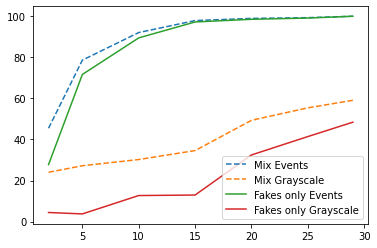

In [12]:
import matplotlib.pyplot as plt
# fakes= df.xs('Events').index.values
# ev_mix = df.loc[('Events'), 'Deepfakes_v1-S3DFM'].to_numpy(dtype=float)
# gs_mix = df.loc[('Grayscale'), 'Deepfakes_v1-S3DFM'].to_numpy(dtype=float)
# ev_fakes = df.loc[('Events'), 'Deepfakes_v1'].to_numpy(dtype=float)
# gs_fakes = df.loc[('Grayscale'), 'Deepfakes_v1'].to_numpy(dtype=float)

fakes=[2, 5, 10, 15, 20, 25, 29]
ev_mix = [45.47, 78.63, 92.06, 97.89, 98.95, 99.31, 100.]
gs_mix = [24.01, 27.20, 30.22, 34.59, 49.32, 55.39, 59.08]
ev_fakes = [ 27.77, 71.65, 89.46, 97.21, 98.51, 99.12, 100.00 ]
gs_fakes = [ 4.43, 3.74, 12.69, 12.93, 32.45, 41.40, 48.42 ]


plt.plot(fakes, ev_mix, '--', label='Mix Events')
plt.plot(fakes, gs_mix, '--', label='Mix Grayscale')
plt.plot(fakes, ev_fakes, '', label='Fakes only Events')
plt.plot(fakes, gs_fakes, '', label='Fakes only Grayscale')
plt.legend()


# DATASET CLIPS EVENTS & GRAYSCALE

## Raw Data

In [39]:
from nebfir.env import *
from nebfir.tools.tools_visualization import view_multi_frames_plt
from nebfir.jupyter_GUIS import create_double_selection, get_widgets_output
from IPython.display import clear_output, display
from ipywidgets.widgets import IntSlider


global FRAMES_NUMBER
FRAMES_NUMBER=4

out = get_widgets_output()

def choose_clip(**kwargs):
    global FRAMES_NUMBER

    clear_output()
    clip_path = list(kwargs.values())[0]
    if not clip_path:
        return
    
    print('FRAMES_NUMBER:', FRAMES_NUMBER, '\nClip Path:', clip_path)
    
    clip = np.load(clip_path)
    print('Clip Shape', clip.shape)
    
    # Visualize clip
    view_multi_frames_plt(clip[:, :FRAMES_NUMBER, ... ], figsize=(10,10))




available_clips = lambda sub_path: sorted(glob(f'data/datasets/{sub_path}/*'))

folders_dict = {
    'NVFSD_events':available_clips('NVFSD/Clips/AETS_40ms'),

    'SynFED_s3dfm_events':available_clips('SynFED/Clips/s3dfm/AETS_40ms'),
    'SynFED_s3dfm_grayscale':available_clips('SynFED/Clips/s3dfm/grayscale'),
    'SynFED_deepfakes_v1_events':available_clips('SynFED/Clips/deepfakes_v1/AETS_40ms'),
    'SynFED_deepfakes_v1_grayscale':available_clips('SynFED/Clips/deepfakes_v1/grayscale'),
    'SynFED_deepfakes_v2_events':available_clips('SynFED/Clips/deepfakes_v2/AETS_40ms'),
    'SynFED_deepfakes_v2_grayscale':available_clips('SynFED/Clips/deepfakes_v2/grayscale'),
    'SynFED_deepfakes_v3_events':available_clips('SynFED/Clips/deepfakes_v3/AETS_40ms'),
    'SynFED_deepfakes_v3_grayscale':available_clips('SynFED/Clips/deepfakes_v3/grayscale'),
         }

select1, select2 = create_double_selection(choose_clip, folders_dict)



slider = IntSlider(value=FRAMES_NUMBER, min=1, max=20, step=1)
def update_frames_number(*args):
    global FRAMES_NUMBER
    FRAMES_NUMBER = slider.value
slider.observe(update_frames_number)


display(slider, select1, select2 , out)

IntSlider(value=4, max=20, min=1)

interactive(children=(Select(description='aux_name', options=('NVFSD_events', 'SynFED_s3dfm_events', 'SynFED_s…

interactive(children=(Select(description='name', layout=Layout(width='1500px'), options=('data/datasets/NVFSD/…

Output()

## Dataloader Data

In [1]:
from nebfir.env import *
from nebfir.jupyter_GUIS import get_widgets_output, create_button, create_double_selection
from nebfir.dataloader import EventsDataset
from nebfir.tools.tools_visualization import view_multi_frames_plt

from IPython.display import clear_output, display
from ipywidgets.widgets import IntSlider
from torch.utils.data import DataLoader

from nebfir.imop.transformations import random_erase_box as random_eraseT
from nebfir.imop.transformations import affine as affineT


DEBUG=False
BATCHSIZE=1


global dataloader



out = get_widgets_output()

def update_dataset(**kwargs):
    global dataloader
    clear_output()
    
    list_path = list(kwargs.values())[0]
    if not list_path:
        return
    
    
    dataset = EventsDataset(csv_file=list_path, DEBUG=DEBUG)

    dataloader = DataLoader(
        dataset,
        batch_size=BATCHSIZE,
        shuffle=False,
        num_workers=8,
        pin_memory=False,
        drop_last=False,
    )


    print((dataset))
    print('dataset size', len(dataset))
    print('dataloader size', len(dataloader))
    

@out.capture()
def get_next_batch(*args, **kwargs):
    global dataloader
    
    clear_output()
    
    next_batch = next(iter(dataloader))
    
    print(next_batch['clip'].shape)
    print('Folder', next_batch['folder'][0], '| Label',next_batch["label"].item(), '| User',next_batch["user"].item(), '| Rec', next_batch["recording"].item())
    batch = next_batch['clip']

    ########################################################
    ################# DATA AUGMENTATION ####################
    ########################################################
    prob=.3
    angle, scale, deltax, deltay = 15, 0.75, 30, 30

    batch = random_eraseT(batch.cpu().numpy(), prob=prob)
    batch = affineT(batch, angle=angle, scale=scale, deltax=deltax, deltay=deltay)
    ########################################################
    ########################################################
    ########################################################


    view_multi_frames_plt(batch[0, ...], figsize=(10,10))
    
     

available_lists = lambda split, data_type: sorted(glob(f'data/inp/lists/*{split}*{data_type}*'))

folders_dict = {
    'train_events':available_lists('TRAIN', 'events'),
    'test_events':available_lists('TEST', 'events'),
    'train_grayscale':available_lists('TRAIN', 'grayscale'),
    'test_grayscale':available_lists('TEST', 'grayscale'),
    
}



select1, select2 = create_double_selection(update_dataset, folders_dict)

button = create_button(get_next_batch ,'Get next batch')

display(select1, select2, button, out)



interactive(children=(Select(description='aux_name', options=('train_events', 'test_events', 'train_grayscale'…

interactive(children=(Select(description='name', layout=Layout(width='1500px'), options=('data/inp/lists/NVFSD…

Button(button_style='success', description='Get next batch', style=ButtonStyle())

Output()

# ACTIVATION IMAGES

In [48]:
from nebfir.dataloader import EventsDataloader, EventsDataset
from nebfir.model.net_builder import Net
from nebfir.config.configurations import Configurations

import torch
from torch.utils.data import DataLoader

net_key='i3d'
USER_NO=Configurations.get_config('config-17.yml')['userno']
tlist=Configurations.get_config('config-17.yml')['lists']['test']
device='cpu' # 'cpu' 'cuda:0
model_path='data/out/weights/model_EXP17_2022-05-11_14h10m25s_s1_c40_dur500_AETS_40ms_40ms_minvalloss_ep10.pth'

net = Net(net_key=net_key, classes=USER_NO, device=device)


dataloader = DataLoader(EventsDataset(tlist), batch_size=1, shuffle=True, pin_memory=False)
# dataloader = EventsDataloader(EventsDataset(tlist), batch_size=1, shuffle=True)
# dataloader = EventsDataloader(EventsDataset('data/inp/lists/test_events_test-split30_S1_Fdeepfakes_v1_U0--29_R0--29_fakeno-10_v4.csv'), batch_size=1, shuffle=True)
# dataloader = EventsDataloader(EventsDataset('DATA/lists/test_grayscale_test-split30_S40_Fdeepfakes_v1_U0--29_R0--29_fakeno-10_v4.csv'), batch_size=1, shuffle=True)
data = iter(dataloader)

net.model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
net.model.eval() 

net.model.toggle_activation_mode()

Activation Mode: True


label:  23 | user:  23 | recording:  1


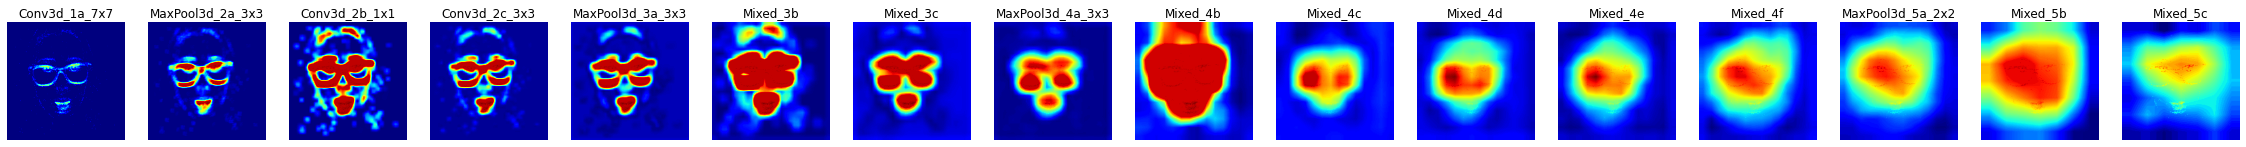

In [49]:
from nebfir.tools.tools_visualization import view_multi_frames_plt

import numpy as np
import cv2
from PIL import Image

data_ = next(data)
print('label: ', data_['label'].item(), '| user: ', data_['user'].item(), '| recording: ', data_['recording'].item())

with torch.no_grad():

    out = net.model( data_['clip'].view(-1, 1, 12,224,224).to(device) / 255. )
    
    if net.model.activation_mode:
        pred, x_list = out
    else:
        pred = out
        

    imgs = []
    titles_list = []
    for n, arr in x_list:
        arr = arr.cpu().numpy()
        shp = arr.shape[1] * arr.shape[2]

        activation_im = np.reshape(arr, newshape=(shp, arr.shape[3],arr.shape[4])) * 255  # convert torch tensor to uint8
        mean_activation = activation_im.mean(axis=0) # Mean over channel and time
        mean_activation = cv2.resize(mean_activation, (224, 224)) # Resize to shape (224, 224)
        # print(arr.max(), mean_activation.max())
        im1 = Image.fromarray( data_['clip'][0].cpu().numpy()[0,0,...]).convert('L')#.astype(np.uint8))#
        # im2 = Image.fromarray(mean_activation.astype(np.uint8))
        im2 = Image.fromarray(mean_activation).convert('L')#.astype(np.uint8))

        im3 = np.array(Image.blend(im1, im2, .95))

        imgs.append(im3)
        # imgs.append(np.array(im2))
        # imgs.append(mean_activation)
        titles_list.append(n)

    view_multi_frames_plt(np.expand_dims(np.array(imgs), 0), cmap='jet', figsize=(40,40), imgs_title_list=titles_list, figshape=(1,16))


torch.cuda.empty_cache()


# SCHEDULER STEPS

Text(0.5, 1.0, 'Learning rate')

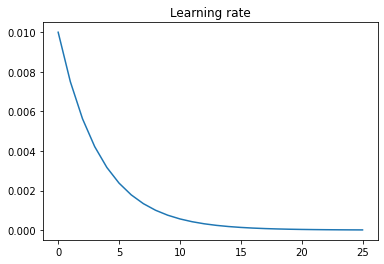

In [1]:
import matplotlib.pyplot as plt
import numpy as np

max_=1e-2
min_ = 1e-5

val_list=[]
def rec(val_list):
    val_list.append(val_list[~0]*.75) #if round(np.random.random()) else val_list.append(val_list[~0])
    return rec(val_list) if val_list[~0] > min_ else val_list

l=rec([max_])

plt.plot(l)
plt.title('Learning rate')
# plt.yscale('log')


In [2]:
import numpy as np

stride=38
framesPerClip=12

events_fno=(24-12)/1+1

grayscale_frames = np.arange(500)


for k in range(13):
    frames_list = list(np.arange(stride*k , stride*k + framesPerClip*3, step=3)) 
    print(frames_list)


[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]
[38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71]
[76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109]
[114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147]
[152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185]
[190, 193, 196, 199, 202, 205, 208, 211, 214, 217, 220, 223]
[228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261]
[266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299]
[304, 307, 310, 313, 316, 319, 322, 325, 328, 331, 334, 337]
[342, 345, 348, 351, 354, 357, 360, 363, 366, 369, 372, 375]
[380, 383, 386, 389, 392, 395, 398, 401, 404, 407, 410, 413]
[418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 451]
[456, 459, 462, 465, 468, 471, 474, 477, 480, 483, 486, 489]
